In [545]:
import pandas as pd
import numpy as np
import math

import sys
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from sklearn import model_selection
from sklearn import preprocessing
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [546]:
class Preprocessor:
    def __init__(self) -> None:
        self.scalers = []

    def dropUnnamedColumn(self, df):
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns="Unnamed: 0")
        if "Unnamed" in df.columns:
            df = df.drop(columns="Unnamed: 0")
        if "" in df.columns:
            df = df.drop(columns="Unnamed: 0")
        return df

    def fillMissingData(self, df):
        df = df.interpolate(method='linear',axis=1, inplace=False)
        return df

    def scaleData(self, df):
        self.scaler = preprocessing.MinMaxScaler()
        df = self.scaler.fit_transform(df)
        self.scalers.append(self.scaler)
        return df

    def saveScalers(self):
        pickle.dump(self.scalers, open("/home/michal/Desktop/UniversityOfEssex/MasterProject/22-24_CE901-CE911-CF981-SU_kaczmarczyk_michal_p/dataHandler/scalers/scaler.pickle", "wb"))


    def dropDuplicates(self, df):
        df = df.drop_duplicates(subset="Date", keep='last', inplace=False, ignore_index=True)
        return df

    def sortValuesByDate(self, df):
        df = df.sort_values(by = "Date")
        return df

    def addChangeFeature(self, df):
        prices = df["Close"]
        change = np.zeros([len(df), 1])
        for i in range(len(df)-1):
            increase = prices[i+1] - prices[i]
            change[i+1] = (increase/prices[i])*100
        df["Change[%]"] = change
        return df

    def leaveDataSinceDate(self, df, date = '2012-01-01'):
        return df.loc[(df['Date'] >= date)]

In [547]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


__Accesing data__

In [548]:
directory = "/content/drive/MyDrive/MasterProject/data/Bloomberg/"
files = os.listdir(directory)
files = [f for f in files if os.path.isfile(directory+'/'+f)]
files
files = ["RR.L.csv"]

In [549]:
dataDir = "/content/drive/MyDrive/MasterProject/data/data/"
dataset = []
for file in files:
    df = pd.read_csv(dataDir + file).set_index("Date")
    df.index = pd.to_datetime(df.index)
    bl = pd.read_csv(directory + file).set_index("Date")
    bl.index = pd.to_datetime(bl.index)
    bl = bl["Price Earnings Ratio \n(P/E) \n(RR/ LN Equity)"]
    bl = bl.resample('D')
    bl = bl.ffill()
    bl = bl.bfill()
    df = df.join(bl, how="inner")
    dataset.append(df)

__Splitting data__

In [550]:
trainDataset = []
testDataset = []
preprocessor = Preprocessor()
i=0
for df in dataset:
    df.insert(0, "Date", df.index)
    df = preprocessor.leaveDataSinceDate(df)
    #if files[i] == "RR.L.csv":
    train, test = model_selection.train_test_split(df, test_size=0.2, shuffle=False)
    trainDataset.append(train)
    testDataset.append(test)
    #else:
    #    trainDataset.append(df)
    i+=1

__Preprocessing data__

In [551]:
preprocessor = Preprocessor()
for i in range(len(trainDataset)):
    trainDataset[i] = preprocessor.dropUnnamedColumn(trainDataset[i])
    trainDataset[i] = preprocessor.dropDuplicates(trainDataset[i])
    trainDataset[i] = preprocessor.addChangeFeature(trainDataset[i])
    columns = trainDataset[i].columns
    trainDataset[i][columns[1:]] = preprocessor.fillMissingData(trainDataset[i][columns[1:]])
    trainDataset[i][columns[1:]] = preprocessor.scaleData(trainDataset[i][columns[1:]])
    trainDataset[i] = preprocessor.sortValuesByDate(trainDataset[i])
    trainDataset[i].set_index("Date", inplace = True)

In [552]:
preprocessor = Preprocessor()
for i in range(len(testDataset)):
    testDataset[i] = preprocessor.dropUnnamedColumn(testDataset[i])
    testDataset[i] = preprocessor.dropDuplicates(testDataset[i])
    testDataset[i] = preprocessor.addChangeFeature(testDataset[i])
    columns = testDataset[i].columns
    testDataset[i][columns[1:]] = preprocessor.fillMissingData(testDataset[i][columns[1:]])
    testDataset[i][columns[1:]] = preprocessor.scaleData(testDataset[i][columns[1:]])
    testDataset[i] = preprocessor.sortValuesByDate(testDataset[i])
    testDataset[i].set_index("Date", inplace = True)

#preprocessor.saveScalers()

In [553]:
trainDataset[0]

,Open,High,Low,Close,Adj Close,Volume,Price Earnings Ratio \n(P/E) \n(RR/ LN Equity),Change[%]
Date,,,,,,,,
2014-06-27,0.959673,0.969492,0.968438,0.974500,0.902035,0.035655,0.081934,0.308960
2014-06-30,0.978050,0.970217,0.968438,0.974500,0.902035,0.044695,0.042722,0.308960
2014-07-01,0.973966,0.969581,0.975565,0.975520,0.902990,0.034988,0.042722,0.310437
2014-07-02,0.981113,0.976275,0.961311,0.953080,0.881989,0.034193,0.042722,0.276492
2014-07-03,0.954569,0.965169,0.962533,0.968380,0.896308,0.041117,0.042722,0.331562
...,...,...,...,...,...,...,...,...
2022-05-23,0.135479,0.134483,0.140768,0.131244,0.134145,0.086532,0.335248,0.305738
2022-05-24,0.128190,0.127087,0.134775,0.122149,0.124849,0.153849,0.335248,0.250840
2022-05-25,0.124590,0.130620,0.135250,0.132374,0.135300,0.099908,0.335248,0.376795


__Creating training sequences__

In [554]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

features = len(trainDataset[0].iloc[0])
samplesForPrediction = 10
samplesPredicted = 1

trainDates = trainDataset[0].index[samplesForPrediction+1:]
testDates = testDataset[0].index[samplesForPrediction+1:]
xTrain = []
yTrain = []
xTest = []
yTest = []
for df in trainDataset:
    trainX, trainY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTrain += trainX
    yTrain += trainY
for df in testDataset:
    testX, testY = createSequence(df, df["Close"], samplesForPrediction, samplesPredicted)
    xTest += testX
    yTest += testY

__Making pyTorch Dataset__

In [555]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [556]:
xTrain = torch.Tensor(xTrain).to(device)
yTrain = torch.Tensor(yTrain).to(device)
xTest = torch.Tensor(xTest).to(device)
yTest = torch.Tensor(yTest).to(device)

__Model__

In [557]:
print(xTrain.shape)
print(yTrain.shape)
xTrain = xTrain.to(device)
xTest = xTest.to(device)
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xTrain, yTrain), shuffle=False, batch_size=4)
for inputData, desired in loader:
    print(inputData.shape)
    print(desired.shape)
    break

#xTrain = xTrain.permute(1, 0, 2).to(device)
#xTest = xTest.permute(1, 0, 2).to(device)
#print(xTrain.shape)
#print(device)

torch.Size([1992, 10, 8])
torch.Size([1992, 1])
torch.Size([4, 10, 8])
torch.Size([4, 1])


In [558]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.feature_size = feature_size
        self.embedding = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim * 4, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.l1 = nn.LSTM(input_size = hidden_dim, hidden_size = 512, num_layers = 1, bidirectional = True, device = device)
        self.fc_out = nn.Linear(1024, 1)  # Predicting 1 value for the next day

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.feature_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[-1, :, :]
        #output = output.unsqueeze(0)
        output, _ = self.l1(output)
        output = self.fc_out(output[-1])  # Output of the last time step
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [559]:
# Initialize the model, loss function, and optimizer
model = TimeSeriesTransformer(feature_size=8, num_heads=6, num_layers=3, hidden_dim=240).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [560]:
print(model)

TimeSeriesTransformer(
  (embedding): Linear(in_features=8, out_features=240, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240, out_features=960, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=960, out_features=240, bias=True)
        (norm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (l1): LSTM(240, 512, bidirectional=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
)

In [567]:

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in loader:
        X_batch, y_batch = batch
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)

        # Compute loss
        loss = criterion(predictions, y_batch)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    #120


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.0015
Epoch 2/10, Loss: 0.0015
Epoch 3/10, Loss: 0.0012
Epoch 4/10, Loss: 0.0011
Epoch 5/10, Loss: 0.0013
Epoch 6/10, Loss: 0.0014
Epoch 7/10, Loss: 0.0016
Epoch 8/10, Loss: 0.0013
Epoch 9/10, Loss: 0.0012
Epoch 10/10, Loss: 0.0011


__Testing__

In [568]:
xTrain.shape

torch.Size([1992, 10, 8])

<ipython-input-573-22a219d922bf>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [float(arr) for arr in y_pred]


Total Mean Squared Error: 0.0011379064520136424
Total Mean Absolute Error: 0.02696029230380472
Total Mean Absolute Percentage Error: 0.03373286901545201


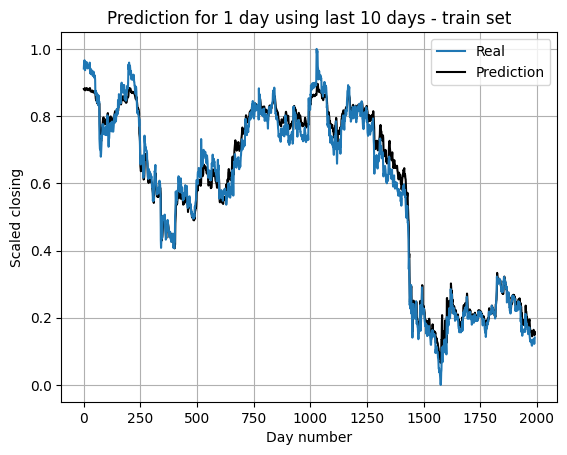

In [573]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
y_pred = []
y_real = []

with torch.no_grad():  # Disable gradient computation for efficiency
    for X_batch, y_batch in zip(xTrain, yTrain):
        # Forward pass
        predictions = model(X_batch)
        # Collect predictions and targets for further analysis
        y_pred.append(predictions.cpu().numpy())
        y_real.append(y_batch.cpu().numpy())

y_pred = [float(arr) for arr in y_pred]
y_real = [float(arr[0]) for arr in y_real]

# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(y_real, y_pred)
mae_total = mean_absolute_error(y_real, y_pred)
rmse_total = mean_squared_error(y_real, y_pred, squared=False)
print(f'Total Mean Squared Error: {mse_total}')
print(f'Total Mean Absolute Error: {mae_total}')
print(f'Total Mean Absolute Percentage Error: {rmse_total}')

fig, ax = plt.subplots()
#ax.plot(trainDates, real, zorder = 3)
#ax.plot(trainDates, predictions, color = 'black', zorder = 2)
ax.plot(y_real, zorder = 3)
ax.plot(y_pred, color = 'black', zorder = 2)

# Rotate date labels for better readability
#plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
#locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
#ax.xaxis.set_major_locator(locator)


ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()



<ipython-input-576-ffdd469b6d65>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [float(arr) for arr in y_pred]
<ipython-input-576-ffdd469b6d65>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummyDataset["Close"] = predictions
<ipython-input-576-ffdd469b6d65>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummyDatas

Total Mean Squared Error: 0.0021922917260627475
Total Mean Absolute Error: 0.036729296099641644
Total Mean Absolute Percentage Error: 0.04682191501917395


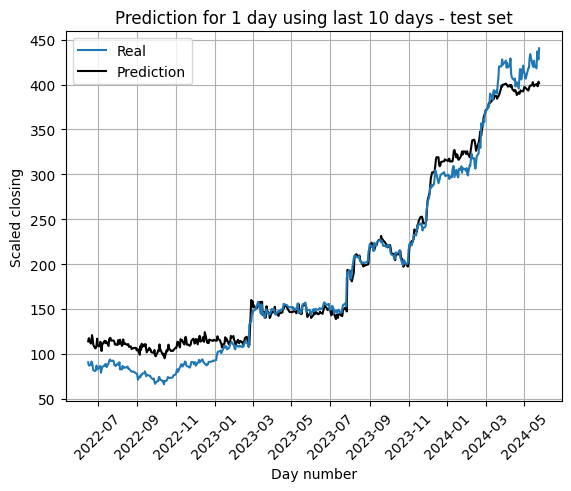

In [576]:
test_loss = 0
y_pred = []
y_real = []

with torch.no_grad():  # Disable gradient computation for efficiency
    for X_batch, y_batch in zip(xTest, yTest):
        # Forward pass
        predictions = model(X_batch)
        # Collect predictions and targets for further analysis
        y_pred.append(predictions.cpu().numpy())
        y_real.append(y_batch.cpu().numpy())

y_pred = [float(arr) for arr in y_pred]
y_real = [float(arr[0]) for arr in y_real]


# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(y_real, y_pred)
mae_total = mean_absolute_error(y_real, y_pred)
rmse_total = mean_squared_error(y_real, y_pred, squared=False)
print(f'Total Mean Squared Error: {mse_total}')
print(f'Total Mean Absolute Error: {mae_total}')
print(f'Total Mean Absolute Percentage Error: {rmse_total}')

real = y_real
predictions = y_pred

#Rescaling
dummyDataset = testDataset[0].tail(len(predictions))
dummyDataset["Close"] = predictions
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
predictions = dummyDataset[:,3]

dummyDataset = testDataset[0].tail(len(real))
dummyDataset["Close"] = real
dummyDataset = preprocessor.scaler.inverse_transform(dummyDataset)
real = dummyDataset[:,3]

fig, ax = plt.subplots()
ax.plot(np.array(testDates)[:], real[:], zorder = 3)
ax.plot(np.array(testDates)[:], predictions[:], color = 'black', zorder = 2)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - test set")
plt.show()



__Profit Calculation__

In [571]:
profit = 0
lastBuy = 0
action = []
for realVal, predVal in zip(real[:-samplesPredicted], predictions[samplesPredicted::samplesPredicted]):
    if(realVal<predVal and lastBuy == 0):
        lastBuy = realVal
        action.append(1)
    elif(realVal > predVal and lastBuy > 0):
        profit += realVal - lastBuy
        lastBuy = 0
        action.append(-1)
    else:
        action.append(0)

if(lastBuy>0):
    profit += realVal - lastBuy
    lastBuy = 0
    action.append(-1)
else:
    action.append(0)

print(profit)

216.1400086361146


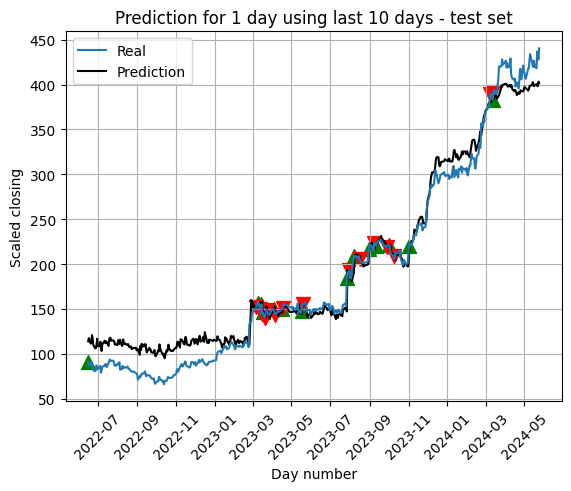

In [572]:
real = real[:]
predictions = predictions[:]
testDates = testDates[:]
action = np.array(action[:])

buy_dates = np.array(testDates)[action == 1]
sell_dates = np.array(testDates)[action == -1]

buy_prices = real[action == 1]
sell_prices = real[action == -1]

fig, ax = plt.subplots()
ax.plot(np.array(testDates), real, zorder = 3)
ax.plot(np.array(testDates), predictions, color = 'black', zorder = 2)

ax.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='Buy')
ax.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Sell')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - test set")
plt.show()

